In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
str_to_inx = {str:inx for inx, str in enumerate(chars, start=1)}
str_to_inx['.'] = 0
inx_to_str = {str:inx for inx, str in str_to_inx.items()}
inx_to_str

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [29]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for word in words:
    word = block_size * '.' + word + '.'
    # for ch1, ch2, ch3, ch4 in zip(word, word[1:], word[2:], word[3:]):
    #     # print(''.join([ch1, ch2, ch3]), '=>', ch4)
    #     X.append([str_to_inx[ch] for ch in [ch1, ch2, ch3]])
    #     Y.append(str_to_inx[ch4])
    end_inx = block_size
    for start_inx, char in enumerate(word[block_size:]):
        X.append([str_to_inx[ch] for ch in word[start_inx:end_inx]])
        Y.append(str_to_inx[char])
        end_inx += 1


X, Y = torch.tensor(X), torch.tensor(Y)
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [5]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [6]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [159]:
# find the best learning rate in [0.001, 1]
learning_rates_exponent = torch.linspace(start=-3, end=0, steps=1000) # 10**(-3) = 0.001, 10**0 = 1
learning_rates = 10**learning_rates_exponent # exponential step
learning_rates

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

Why use batches? Training time. A lot of semi-accurate steps bets a small # of accurate steps(the whole training set)

In [173]:
# train
l = []
losses = []
for i in range(1000):
    # minibatch construct
    inx = torch.randint(0, X.shape[0], (32,))

    # forward pass
    emb = C[X[inx]] # grab only those rows from the minibatch 
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[inx]) + 0.001*(W2**2).mean()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    l_r = learning_rates[i]
    for p in parameters:
        p.data += -l_r * p.grad

    #stats
    l.append(learning_rates_exponent[i])
    losses.append(loss.item())
loss

tensor(4.5779, grad_fn=<AddBackward0>)

tensor(0.2783)

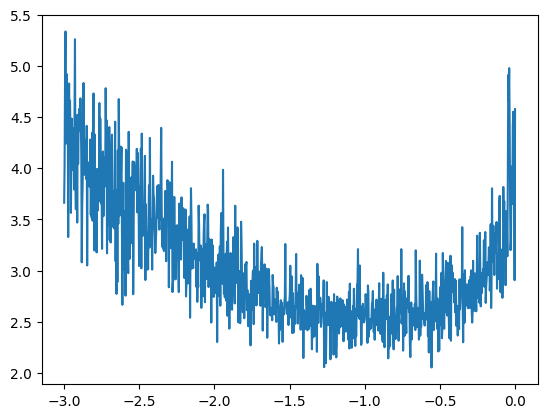

In [174]:
plt.plot(l, losses)
learning_rates[np.argmin(losses)]

In [139]:
emb = C[X] # grab only those rows from the minibatch 
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) + 0.001*(W2**2).mean()
loss

tensor(2.4960, grad_fn=<AddBackward0>)

In [140]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
	out = []
	context = [0] * block_size # initialize with all ...
	while True:
		emb = C[torch.tensor([context])] # (1,block_size,d)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1, generator=g).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break
    
	print(''.join(inx_to_str[i] for i in out))

careah.
aal.
harihkimlix.
taty.
salassa.
jarheen.
deliyha.
kaeli.
neronia.
ceriiv.
kale.
gvv.
bmo.
din.
qesan.
sroilea.
jadii.
watelo.
dearyni.
jane.
